In [2]:
from PIL import Image
import numpy as np

In [3]:
image_raw = Image.open("assets/cat.jpg")

In [4]:
IMG_SIZE = (1920,1080)

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

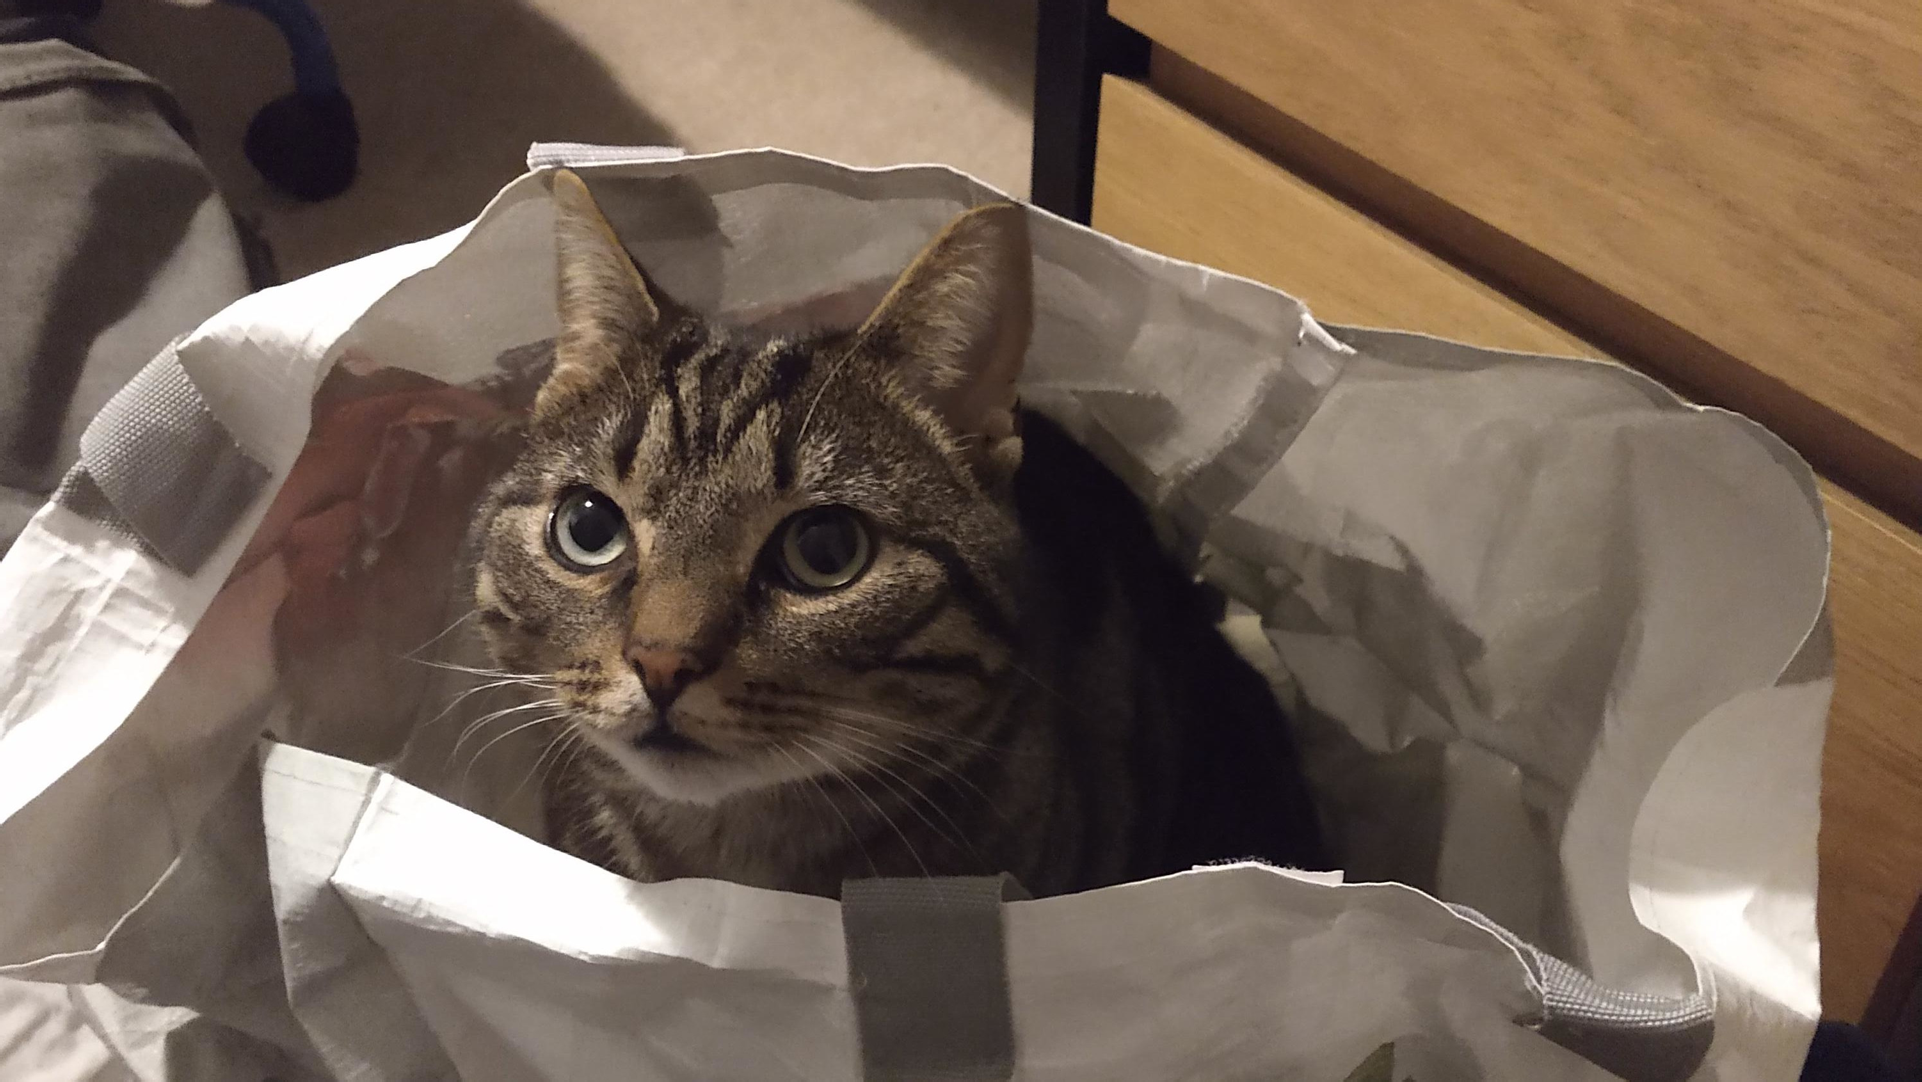

In [5]:
Image.fromarray(image_array_padded, 'RGB')

In [6]:
from pynq import Overlay
from pynq import allocate
#import pynq_sobel
import os
Kernel_Overlay = Overlay("Convolver_wrapper.bit")

In [7]:
Kernel_Overlay?

In [8]:
# Input array for DMA use
kernel_in_dma_array  = allocate(shape=(IMG_SIZE[1], IMG_SIZE[0], 4), dtype=np.uint8)

# Output array for DMA use
kernel_out_dma_array = allocate(shape=(IMG_SIZE[1],IMG_SIZE[0]), dtype=np.uint32)

In [12]:
def do_conv(image_array, thresh=30,Kernel = [0, -1, 0, -1, 5, -1, 0, -1, 0]):

    # Set overlay threshold
    Kernel_Overlay.general_filter_0.write(0x24, thresh)
    
    
    Kernel_Overlay.general_filter_0.write(0x20, Kernel[0]) #W00 
    Kernel_Overlay.general_filter_0.write(0x1C, Kernel[1]) #W01
    Kernel_Overlay.general_filter_0.write(0x18, Kernel[2]) #W02
    Kernel_Overlay.general_filter_0.write(0x14, Kernel[3]) #W10
    Kernel_Overlay.general_filter_0.write(0x10, Kernel[4]) #W11
    Kernel_Overlay.general_filter_0.write(0x0C, Kernel[5]) #W12
    Kernel_Overlay.general_filter_0.write(0x08, Kernel[6]) #W20
    Kernel_Overlay.general_filter_0.write(0x04, Kernel[7]) #W21
    Kernel_Overlay.general_filter_0.write(0x00, Kernel[8]) #W22
    
    
    # Copy image array into dma buffer
    kernel_in_dma_array[:, :, :3] = image_array[:, :, :]
    
    
    Kernel_Overlay.axi_dma.recvchannel.transfer(kernel_out_dma_array)
    Kernel_Overlay.axi_dma.sendchannel.transfer(kernel_in_dma_array)
    Kernel_Overlay.axi_dma.sendchannel.wait()
    Kernel_Overlay.axi_dma.recvchannel.wait()
    
    return kernel_out_dma_array

In [13]:
Kernel = [0, -1, 0, -1, 5, -1, 0, -1, 0]

In [14]:
do_conv(image_array,30,Kernel)

RuntimeError: DMA channel not started